# 데이터셋 소개 
- 인스턴스 284.807건
- 사기 거래 총 492건
- 거래 시간 범위 : 0 ~ 172,792
- 거래 금액 : 0 ~ 25,691.16
- 레이블 표시
  + 사기 거래 : 1 표시
  + 정상 거래 : 0 표시

In [1]:
# 라이브러리 불러오기
'''메인 라이브러리'''
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

'''시각화 관련 라이브러리'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

'''데이터 준비 및 모델 평가 관련 라이브러리'''
from scipy.stats import pearsonr
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.decomposition import PCA

# 환경설정
plt.rcParams['font.family'] = 'Malgun Gothic'    #사용 방법1
print(plt.rcParams['font.family'], plt.rcParams['font.size'])   # 폰트확인
mpl.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기
data = pd.read_csv("credit_card.txt")
print(data.shape)
data.head()

['Malgun Gothic'] 10.0
(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
# 피쳐 행렬 및 레이블 배열 생성하기
dataX = data.copy().drop(['Class'],axis=1)
dataY = data['Class'].copy()

featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
scalingFactors = pd.DataFrame(data=[sX.mean_,sX.scale_],index=['Mean','StDev'],columns=featuresToScale)
scalingFactors.head(1)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619


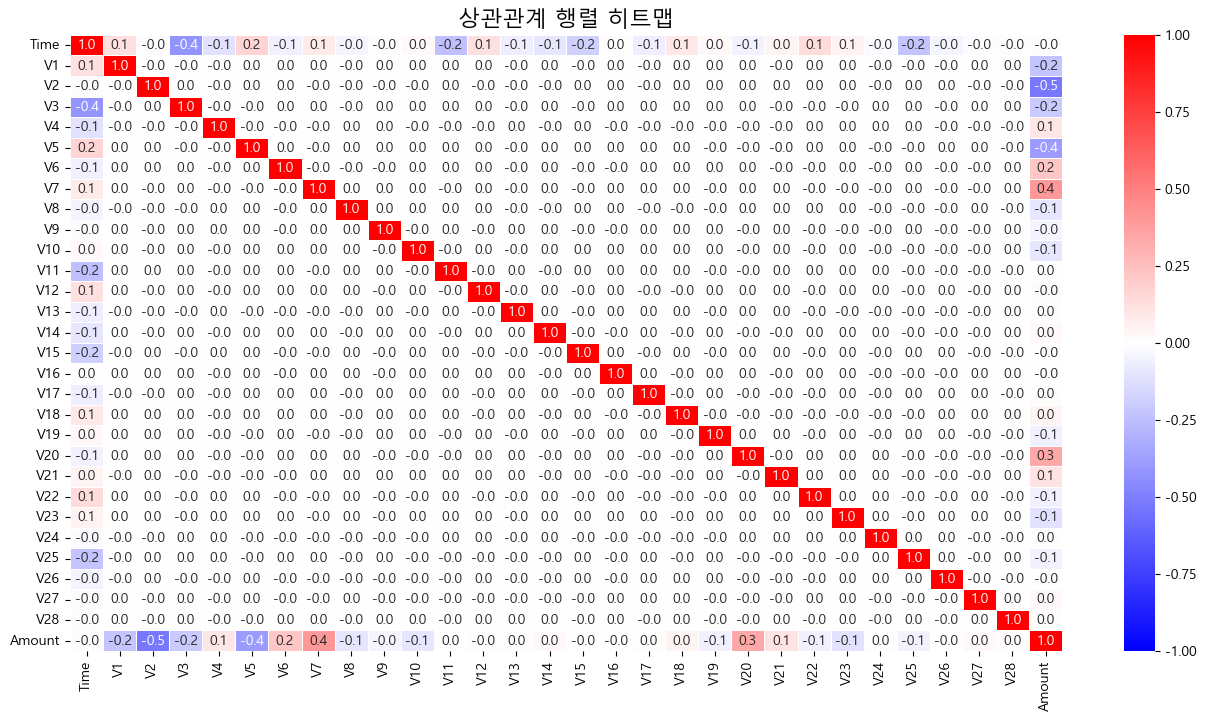

In [3]:
# 피처간 상관관계 확인
correlationMatrix = pd.DataFrame(data=[],index=dataX.columns,columns=dataX.columns)
for i in dataX.columns:
    for j in dataX.columns:
        correlationMatrix.loc[i,j] = np.round(pearsonr(dataX.loc[:,i],dataX.loc[:,j])[0],2)

cmap = LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'white', 'red'])

# matplotlib 그림 설정
plt.figure(figsize=(16, 8))

# 컬러바가 있는 히트맵 그리기
sns.heatmap(correlationMatrix.astype(float), 
            annot=True, 
            fmt='.1f', 
            cmap = cmap, 
            vmin=-1, 
            vmax=1, 
            linewidths=0.5)

# 제목과 라벨 추가
plt.title('상관관계 행렬 히트맵', size=16)
plt.show()

In [4]:
# 층화추출
X_train, X_test, y_train, y_test = train_test_split(dataX, 
                                                    dataY, 
                                                    test_size=0.33, 
                                                    random_state=2024, 
                                                    stratify=dataY)

len(X_train), len(X_test), y_train.sum()/len(y_train), y_test.sum()/len(y_test)

(190820, 93987, 0.0017293784718582959, 0.0017236426314277506)

In [5]:
# 주요 평가 지표 활용 위한 함수
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    
    precision, recall, thresholds = precision_recall_curve(preds['trueLabel'], preds['anomalyScore'])
    average_precision = average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()

    if returnPreds==True:
        return preds

def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)
    plt.show()

최적의 주성분 개수: 27


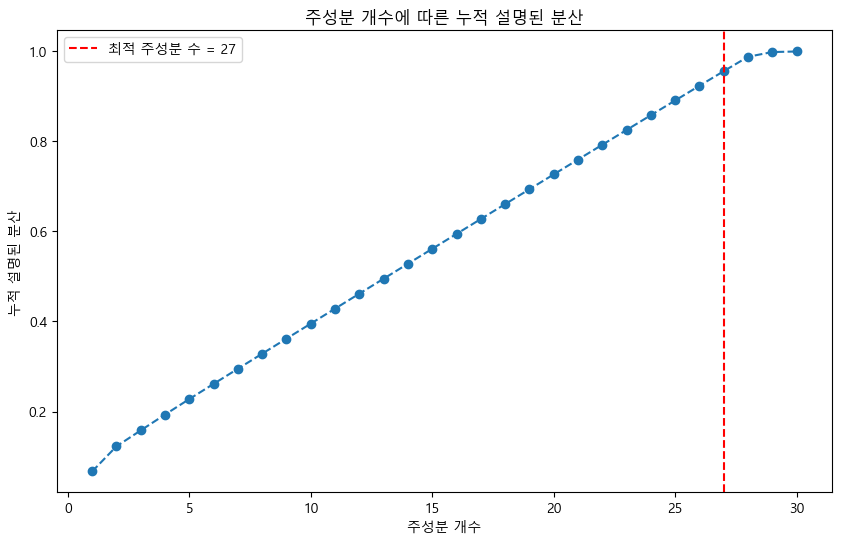

In [6]:
pca = PCA()
pca = pca.fit(X_train)

# 설명된 분산 비율 계산
explained_variance = pca.explained_variance_ratio_

# 누적 설명된 분산 계산
cumulative_explained_variance = np.cumsum(explained_variance)

# 95% 이상의 분산을 설명하는 주성분 개수 찾기
optimal_components = np.argmax(cumulative_explained_variance >= 0.95) + 1

print(f"최적의 주성분 개수: {optimal_components}")

# 누적 설명된 분산 시각화
plt.figure(figsize=(10,6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.axvline(optimal_components, color='r', linestyle='--', label=f'최적 주성분 수 = {optimal_components}')
plt.title('주성분 개수에 따른 누적 설명된 분산')
plt.xlabel('주성분 개수')
plt.ylabel('누적 설명된 분산')
plt.legend()
plt.show()

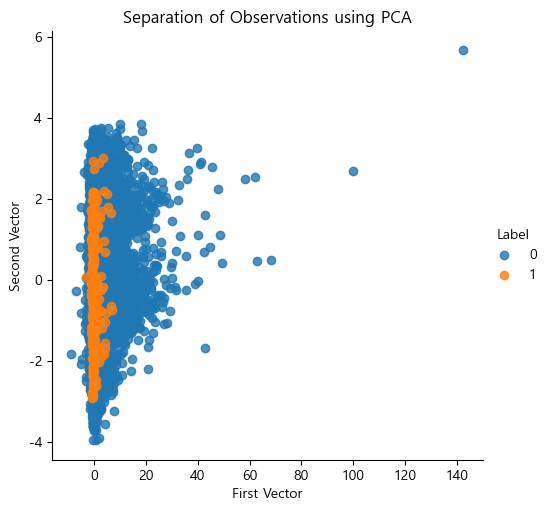

In [7]:
n_components = 27
whiten = False
random_state = 2024

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

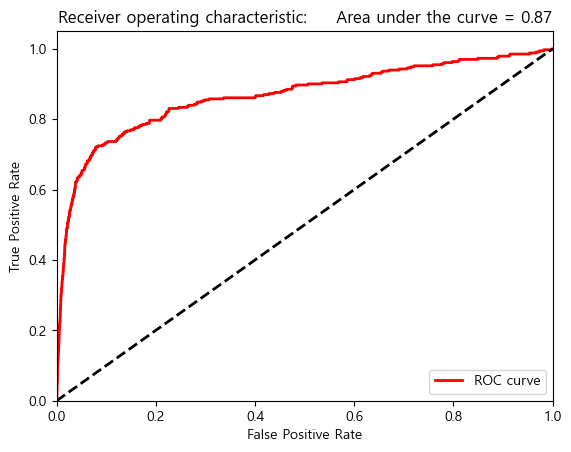

        trueLabel  anomalyScore
90792           0      0.000060
213722          0      0.000213
39234           0      0.000414
177846          0      0.000101
57576           0      0.000902


In [9]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)
print(preds[0:5])